In [12]:
import glob
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
from tqdm.autonotebook import tqdm
import json

class VideoValidator:
    def __init__(self, im_size=112):
        self.im_size = im_size
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.transforms = self._setup_transforms()

    def _setup_transforms(self):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.im_size, self.im_size)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])

    def frame_extract(self, path):
        """Extract frames from video"""
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image
        vidObj.release()

    def validate_video(self, vid_path):
        """Check if video is valid and can be processed"""
        count = 20
        frames = []
        a = int(100/count)
        first_frame = np.random.randint(0, a)
        
        try:
            for i, frame in enumerate(self.frame_extract(vid_path)):
                frames.append(self.transforms(frame))
                if len(frames) == count:
                    break
            frames = torch.stack(frames)
            frames = frames[:count]
            return True, frames
        except Exception as e:
            return False, str(e)

    def process_dataset(self, base_path):
        """Process all videos in the dataset"""
        # Define paths for different video categories
        paths = {
            'real': os.path.join(base_path, "FF_Face_only_data_processed/real"),
            'fake': os.path.join(base_path, "FF_Face_only_data_processed/fake")
        }

        # Get all video files
        video_files = []
        for category in paths.values():
            video_files.extend(glob.glob(os.path.join(category, "*.mp4")))

        print(f"Total number of videos: {len(video_files)}")
        
        # Process videos
        corrupted_videos = []
        valid_videos = []
        frame_counts = []

        for video_path in tqdm(video_files, desc="Validating videos"):
            try:
                # Check if video is valid
                is_valid, result = self.validate_video(video_path)
                
                if is_valid:
                    # Count frames
                    cap = cv2.VideoCapture(video_path)
                    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                    cap.release()
                    
                    if frame_count >= 100:
                        valid_videos.append(video_path)
                        frame_counts.append(frame_count)
                    else:
                        corrupted_videos.append((video_path, "Insufficient frames"))
                else:
                    corrupted_videos.append((video_path, result))
                    
            except Exception as e:
                corrupted_videos.append((video_path, str(e)))

        # Print results
        print("\nProcessing Results:")
        print(f"Total videos processed: {len(video_files)}")
        print(f"Valid videos: {len(valid_videos)}")
        print(f"Corrupted videos: {len(corrupted_videos)}")
        print(f"Average frames per video: {np.mean(frame_counts):.2f}")

        # Print corrupted video details
        if corrupted_videos:
            print("\nCorrupted Videos:")
            for path, error in corrupted_videos:
                print(f"- {os.path.basename(path)}: {error}")
                # Optionally delete corrupted videos
                # os.remove(path)

        return valid_videos, frame_counts

def main():
    # Set up base path
    base_path = "Dataset"  # Modify this to match your dataset location
    
    # Initialize validator
    validator = VideoValidator()
    
    # Process dataset
    valid_videos, frame_counts = validator.process_dataset(base_path)
    
    # Save results
    results = {
        'valid_videos': valid_videos,
        'frame_counts': frame_counts,
        'statistics': {
            'total_valid_videos': len(valid_videos),
            'average_frames': float(np.mean(frame_counts)),
            'min_frames': int(np.min(frame_counts)),
            'max_frames': int(np.max(frame_counts))
        }
    }
    
    # Save results to JSON
    output_path = os.path.join(base_path, "validation_results.json")
    with open(output_path, 'w') as f:
        json.dump(results, f, indent=4)
    
    print(f"\nResults saved to {output_path}")

if __name__ == "__main__":
    main()

Total number of videos: 32


Validating videos: 100%|██████████| 32/32 [00:00<00:00, 107.06it/s]


Processing Results:
Total videos processed: 32
Valid videos: 23
Corrupted videos: 9
Average frames per video: 100.00

Corrupted Videos:
- 01__walk_down_hall_angry.mp4: Insufficient frames
- 01__walking_outside_cafe_disgusted.mp4: Insufficient frames
- 01__walking_down_street_outside_angry.mp4: Insufficient frames
- 01__exit_phone_room.mp4: Insufficient frames
- 01__kitchen_pan.mp4: Insufficient frames
- 01__outside_talking_pan_laughing.mp4: Insufficient frames
- 01_21__walk_down_hall_angry__03X7CELV.mp4: Insufficient frames
- 01_20__outside_talking_pan_laughing__OTGHOG4Z.mp4: Insufficient frames
- 01_12__outside_talking_pan_laughing__TNI7KUZ6.mp4: Insufficient frames

Results saved to Dataset/validation_results.json


In [13]:
#to load preprocessod video to memory
import json
import glob
import numpy as np
import cv2
import copy
import random
video_files =  glob.glob('Dataset/FF_Face_only_data_processed/fake/*.mp4')
video_files += glob.glob('Dataset/FF_Face_only_data_processed/real/*.mp4')
random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<0):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count)
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [100, 100, 98, 100, 100, 100, 100, 92, 100, 100, 100, 100, 100, 35, 15, 100, 100, 100, 100, 64, 100, 100, 100, 97, 100, 100, 99, 89, 100, 100, 98, 100]
Total no of video:  32
Average frame per video: 93.34375


In [14]:
# load the video name and labels from csv
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        temp_video = video_path.split('/')[-1]
        #print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
          label = 0
        if(label == 'REAL'):
          label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
          frames.append(self.transform(frame))
          if(len(frames) == self.count):
            break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        #print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [15]:
#count the number of fake and real videos
import pandas as pd
def number_of_real_and_fake_videos(data_list):
  header_list = ["file","label"]
  lab = pd.read_csv('labels/global_metadata.csv',names=header_list)
  fake = 0
  real = 0
  for i in data_list:
    temp_video = i.split('/')[-1]
    label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
    if(label == 'FAKE'):
      fake+=1
    if(label == 'REAL'):
      real+=1
  return real,fake

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-21..232].


train :  25
test :  7
TRAIN:  Real: 12  Fake: 13
TEST:  Real: 4  Fake: 3


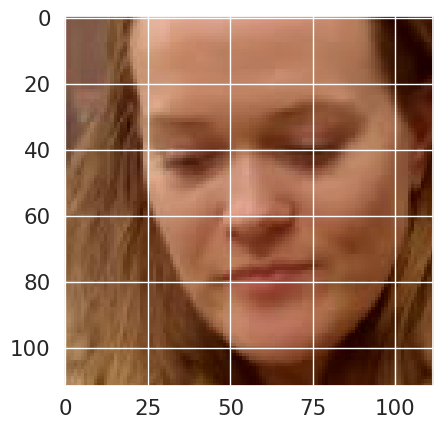

In [16]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["file","label"]
labels = pd.read_csv('labels/global_metadata.csv',names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
# train_videos,valid_videos = train_test_split(data,test_size = 0.2)
# print(train_videos)

print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])

In [17]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))

In [18]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

/home/obito/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/obito/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'content/checkpoint.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [20]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [21]:
def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

[Epoch 1/20] [Batch 6 / 7] [Loss: 0.707500, Acc: 40.00%]Testing
[Batch 1 / 2]  [Loss: 0.695429, Acc: 42.86%]
Accuracy 42.857142857142854
[Epoch 2/20] [Batch 6 / 7] [Loss: 0.659018, Acc: 64.00%]]Testing
[Batch 1 / 2]  [Loss: 0.712461, Acc: 42.86%]
Accuracy 42.857142857142854
[Epoch 3/20] [Batch 6 / 7] [Loss: 0.680912, Acc: 52.00%]Testing
[Batch 1 / 2]  [Loss: 0.727723, Acc: 42.86%]
Accuracy 42.857142857142854
[Epoch 4/20] [Batch 6 / 7] [Loss: 0.688394, Acc: 56.00%]]Testing
[Batch 1 / 2]  [Loss: 0.717654, Acc: 42.86%]
Accuracy 42.857142857142854
[Epoch 5/20] [Batch 6 / 7] [Loss: 0.649254, Acc: 60.00%]Testing
[Batch 1 / 2]  [Loss: 0.734694, Acc: 42.86%]
Accuracy 42.857142857142854
[Epoch 6/20] [Batch 6 / 7] [Loss: 0.616604, Acc: 88.00%]Testing
[Batch 1 / 2]  [Loss: 0.736800, Acc: 42.86%]
Accuracy 42.857142857142854
[Epoch 7/20] [Batch 6 / 7] [Loss: 0.608986, Acc: 80.00%]Testing
[Batch 1 / 2]  [Loss: 0.776738, Acc: 42.86%]
Accuracy 42.857142857142854
[Epoch 8/20] [Batch 6 / 7] [Loss: 0.626

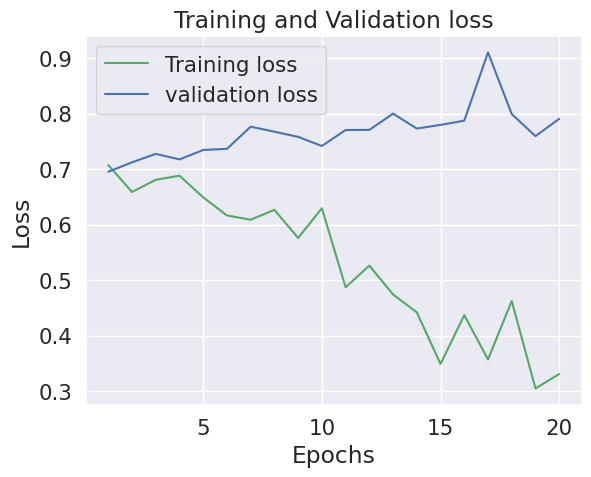

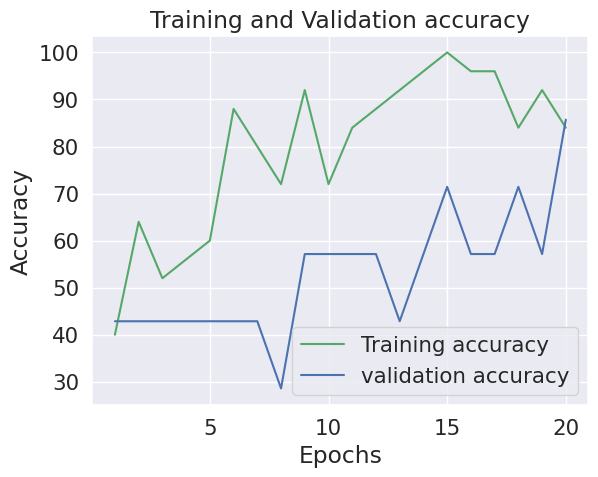

[[3 0]
 [1 3]]
True positive =  3
False positive =  0
False negative =  1
True negative =  3




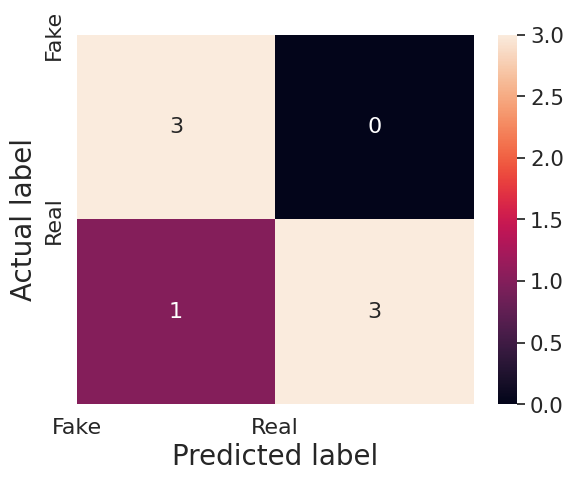

Calculated Accuracy 85.71428571428571


In [22]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs 
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
plot_loss(train_loss_avg,test_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,test_accuracy,len(train_accuracy))
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)